In [1]:
import pandas as pd
import numpy as np

In [2]:
# Read data
data = pd.read_csv('data/HCV-Egy-Data.csv')

In [3]:
X = data.drop(['Baselinehistological staging'], axis=1)
y = data['Baselinehistological staging']
# Check distribution of target classes
y.value_counts()

Baselinehistological staging
4    362
3    355
1    336
2    332
Name: count, dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

array([1, 1, 3, ..., 1, 2, 2])

In [6]:
from sklearn.preprocessing import StandardScaler
# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
from sklearn.model_selection import KFold
# Set up K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
# Store results
accuracies, precisions, recalls, f1s, y_probas = [], [], [], [], []
conf_matrix_total = np.zeros((4, 4), dtype=int)

# K-Fold loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize and train MLPClassifier (simple neural netwrok)
    model = MLPClassifier(hidden_layer_sizes=(20, 20),
                          activation='relu',
                          solver='adam',
                          learning_rate_init=0.01,
                          max_iter=10000,
                          random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
    conf_matrix_total += confusion_matrix(y_test, y_pred)
    if len(y_probas) < 1:
        y_probas = model.predict_proba(X_test)
    else:
        y_probas = y_probas + model.predict_proba(X_test)

In [10]:
print('Accuracy:', np.mean(accuracies))
print('Precision:', np.mean(precisions))
print('Recall:', np.mean(recalls))
print('F1 Score:', np.mean(f1s))
print('Confusion Matrix:')
print(conf_matrix_total)

Accuracy: 0.2584837545126354
Precision: 0.2598548988616247
Recall: 0.25784090578415614
F1 Score: 0.25665951052006253
Confusion Matrix:
[[ 90  80  81  85]
 [100  70  83  79]
 [ 76  88  98  93]
 [ 87  86  89 100]]


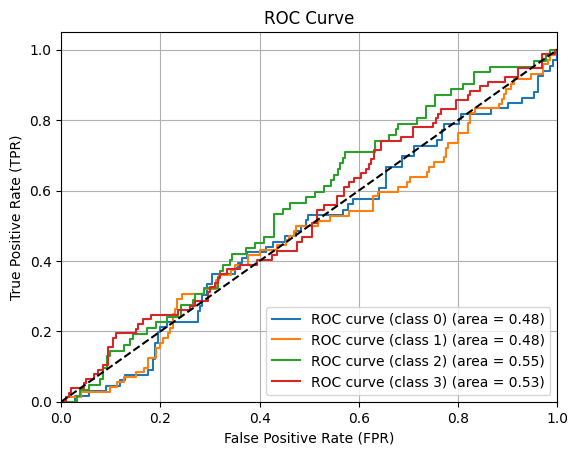

In [11]:
# Get class probabilities for the ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot the ROC curve for each class
n_classes = len(label_encoder.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], label = roc_curve(y_test == i, y_probas[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.grid()
plt.legend(loc='lower right')
plt.show()